# EasyVisa Project

## Context:

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

## Objective:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired your firm EasyVisa for data-driven solutions. You as a data scientist have to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status. 


## Data Description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No 
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment. 
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied


## Primary goal, reduce individuals flagged certified 
- Prioritize precision - we want to reduce false positives 

## Importing necessary libraries and data

In [1]:
import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 100)

#library for finding duplicates
import collections

# Libraries different ensemble classifiers
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Libraries to get different metric scores
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# To tune different models
from sklearn.model_selection import GridSearchCV

#adding easy reference colors for formatting in code
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [3]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [4]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

In [6]:
#import data 
raw = pd.read_csv('EasyVisa.csv')

#creating an initial copy to maintain raw data 
data = raw.copy()

## Data Overview

- Observations
- Sanity checks

### Reviewing shape and columns of data

#### Insights on shape: 
- data has 12 columns and 25.5K rows 
- columns appear to match objective and data definitions 
- a number of possible dummy variables or bins to create 
    - continent
    - yr_of_estab (need to review how many unique variables are there) 
    - region_of_employment
    - unit_of_wage
        - Per FAQ's, will NOT convert into yearly wage as we do not know hrs/week 
- 2 columns to convert into integers (ex: 1,0) instea of objects (ex: Y,N)
    - has_job_experience
    - requires_job_training
    - education_of_employee (can convert into # ordered by value) 
    - full_time_position
    - case_status

In [7]:
#viewing the top 5 rows of data 
data.head().T

,0,1,2,3,4
case_id,EZYV01,EZYV02,EZYV03,EZYV04,EZYV05
continent,Asia,Asia,Asia,Asia,Africa
education_of_employee,High School,Master's,Bachelor's,Bachelor's,Master's
has_job_experience,N,Y,N,N,Y
requires_job_training,N,N,Y,N,N
no_of_employees,14513,2412,44444,98,1082
yr_of_estab,2007,2002,2008,1897,2005
region_of_employment,West,Northeast,West,West,South
prevailing_wage,592.2029,83425.65,122996.86,83434.03,149907.39
unit_of_wage,Hour,Year,Year,Year,Year


In [8]:
#finding the total rows and columns 
data.shape

(25480, 12)

In [9]:
#viewing column data types to anticipate changes and dummy variables 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification? 
- Those with High school education are much less likely to be certified
- Doctorate and Masters are much more likely to be certified 
- Bachelor's are slightly more likely to be certified 

2. How does the visa status vary across different continents? 
- European Employees are significantly more likely to be accepted (79%) 
- African employees are slightly more likely to be certified (72%)
- Asia, North America, and Oceania all 61-65% certified
- South America lowest certification rate (58%) 
 
3. Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status? 
- Those with job experience are only slightly more likely to be certified 
 
4. In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa? 
- Yearly salaries are the most prevelent in the data set and much more likely to be certified
- hourly rates are much less likely to be certified, with week and month being 50/50 with very little representation
 
5. The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?
- prevailing wage does not appear to differ significantly between declined and certified
- Declined individuals have a slightly lower wage distribution than accepted, but only slightly 

#### Additional Questions 
- <b> continent </b> 
    - Distribution
        - Asia is by far the largest demographic, followed by Europe and North America at equal values 
        - Oceana has the samllest representation 
    - Certification Rate
        - Europe has the highest certificaiton rate by far - 78% 
        - Africa is next 72%, then Asia, North America, and Oceana similar rates between 62 and 65% 
        - South America lowest, but not much less at 58% 

- <b> education_of_employee </b> 
    - Most employees have a Bachelor's or Master's
    - followed by similar amounts having High School or Doctorate  

- <b> has_job_experience </b>
    -  slightly more employees have job experience (58%) than not 
    - This surprised me! 

- <b> requires_job_training </b>
    - the majority of employees do <b> not </b> need job experience
    - interestingly, requires job training = N has a lower limit on wage when denied than certified 

- <b> no_of_employees </b>
    - there are some lines with negative number of employees 
        - confirmed with project forum to correct these to absolute values 
    - 75% of companies have 3500 or less employees
    - data is extremely skewed with the mean up to 5k employees and max up to 602K
    - negative correlation with prevailing_wage and yr_of_estab
    - significant number of requests had high level of employees - not considering these as outliers

- <b> yr_of_estab </b>
    - min was 1800, with max up to 2016 
    - most companies between 1975 and 2005
    - negative correlation with no_of_employees

- <b> region_of_employment </b>
    - Distribution
        - Northeast, South, and West each had about 25% of requests 
        - Midwest slightly lower at 17% 
        - Islands quite low, which makes sense as it makes up a small percentage of available regions
    - Certification Rates
        - Midwest has the highest certification rate, 75%
        - Followed by South (70%)
        - West, NE, and Island have rates between 60-63% certification rates 

- <b> prevailing_wage </b>
    - Distribution
        - slightly skewed with the mean 4k higher than median 70k
        - min is 2 - might be data issue/outliers to correct 
        - max is 319K, more possible outliers but feel more confident about upper end  
    - Certification Rate
        - appears that certified indiviuals have a higher prevailing wage across all education levels
        - denied group has lower medians, 25% quartiles, and typically lower top outliers 
    - Negative correlation with no_of_employees
        
- <b> unit_of_wage </b>
    - 90% yearly salary, with a couple hourly and very few weekly or daily 

- <b> full_time_position </b>
    - Distribution
        - 80% full time positions
        - makes sense, this visa process is a lot of work and you want to invest in long term employees for it 
    - Certification Rate
        - full and part time have similar certification rates
- <b> case_status </b>
    - 66.8% Certified, 33% Denied 
    - weill be sure to mirror this in test and train data sets 
    
    
- General Data Quality checks
     - No null values 
     - No duplicate case id's 

In [13]:
#checking for duplicate case_id's 
id = data['case_id'] 
print([item for item, count in collections.Counter(id).items() if count > 1])

[]


In [14]:
data2 = data.drop('case_id', axis = 1)
data2['prevailing_wage'] = data2['prevailing_wage'].astype('int64')

In [15]:
for feature in data2.columns: #loop through columns 
    if data2[feature].dtype == 'int64':
        print(color.BOLD + color.BLUE + feature + color.END)
        print(data2[feature].describe())
        print("")
        print("*"*25)
    if data2[feature].dtype == 'object':
        print (color.BOLD + feature + color.END)
        print(data2[feature].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
        print("")
        print("*"*25)

continent
Asia             66.2%
Europe           14.6%
North America    12.9%
South America     3.3%
Africa            2.2%
Oceania           0.8%
Name: continent, dtype: object

*************************
education_of_employee
Bachelor's     40.2%
Master's       37.8%
High School    13.4%
Doctorate       8.6%
Name: education_of_employee, dtype: object

*************************
has_job_experience
Y    58.1%
N    41.9%
Name: has_job_experience, dtype: object

*************************
requires_job_training
N    88.4%
Y    11.6%
Name: requires_job_training, dtype: object

*************************
no_of_employees
count     25480.000000
mean       5667.043210
std       22877.928848
min         -26.000000
25%        1022.000000
50%        2109.000000
75%        3504.000000
max      602069.000000
Name: no_of_employees, dtype: float64

*************************
yr_of_estab
count    25480.000000
mean      1979.409929
std         42.366929
min       1800.000000
25%       1976.000000
50%      

AxesSubplot(0.125,0.125;0.775x0.755)


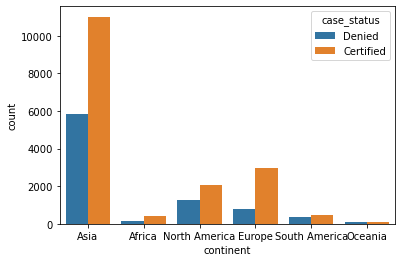

In [16]:
print(sns.countplot(data = data2, x = 'continent',hue='case_status'))

In [17]:
#defining subsets by continent 
data2_Asia = data2.query("continent == 'Asia'")     
data2_Africa = data2.query("continent == 'Africa'") 
data2_North_America = data2.query("continent == 'North America'") 
data2_Europe = data2.query("continent == 'Europe'") 
data2_South_America = data2.query("continent == 'South America'") 
data2_Oceania = data2.query("continent == 'Oceania'")     

In [18]:
#printing certification rates per continent 
print(color.BOLD + "Asia" + color.END)
print(data2_Asia['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

print(color.BOLD + "Africa" + color.END)
print(data2_Africa['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

print(color.BOLD + "North America" + color.END)
print(data2_North_America['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

print(color.BOLD + "Europe" + color.END)
print(data2_Europe['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

print(color.BOLD + "South America" + color.END)
print(data2_South_America['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

print(color.BOLD + "Oceania" + color.END)
print(data2_Oceania['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

#Europe has the highest certificaiton rate by far - 78% 
#Africa is next 72%, then Asia, North America, and Oceana similar rates between 62 and 65% 
#South America lowest, but not much less at 58% 

Asia
Certified    65.3%
Denied       34.7%
Name: case_status, dtype: object

*************************
Africa
Certified    72.1%
Denied       27.9%
Name: case_status, dtype: object

*************************
North America
Certified    61.9%
Denied       38.1%
Name: case_status, dtype: object

*************************
Europe
Certified    79.2%
Denied       20.8%
Name: case_status, dtype: object

*************************
South America
Certified    57.9%
Denied       42.1%
Name: case_status, dtype: object

*************************
Oceania
Certified    63.5%
Denied       36.5%
Name: case_status, dtype: object

*************************


AxesSubplot(0.125,0.125;0.775x0.755)


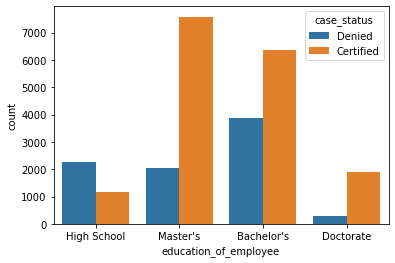

In [19]:
#barplot showing certification rate by education 
print(sns.countplot(data = data2, x = 'education_of_employee',hue='case_status'))

#at first glance it looks like doctorate and Masters are much more likely to be accepted

AxesSubplot(0.125,0.125;0.775x0.755)


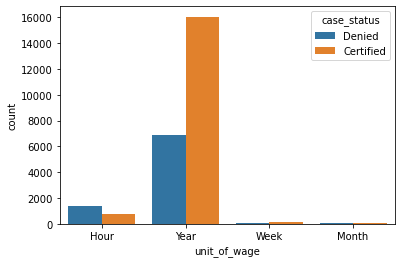

In [20]:
#barplot showing certification rate by unit_of_wage 
print(sns.countplot(data = data2, x = 'unit_of_wage',hue='case_status'))

#Yearly salaries are the most prevelent in the data set and much more likely to be certified 
#hourly rates are much less likely to be certified, with week and month being 50/50 with very little representation

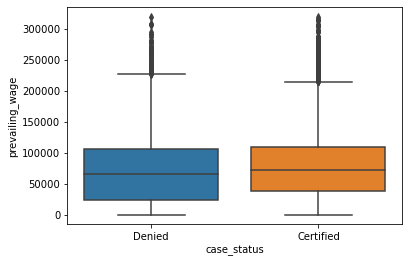

In [21]:
#making box and whisker plots comparing wage and certification status 
sns.boxplot(data = data2, x ='case_status', y ='prevailing_wage');

#wage ranges appear extremely similar between denied and certified individuals 
#outliers reach similar heights
#denied boxplot is slightly smaller than certified 

<AxesSubplot:xlabel='education_of_employee', ylabel='prevailing_wage'>

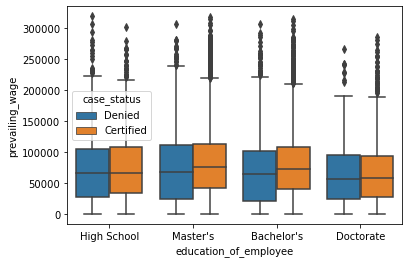

In [22]:
#viewing certification status and wage by education of employee
sns.boxplot(data = data2, x ='education_of_employee', y ='prevailing_wage',hue='case_status')

#appears that certified indiviuals have a higher prevailing wage across all education levels
#denied has lower medians 25% quartiles and typically lower top outliers 

<AxesSubplot:xlabel='requires_job_training', ylabel='prevailing_wage'>

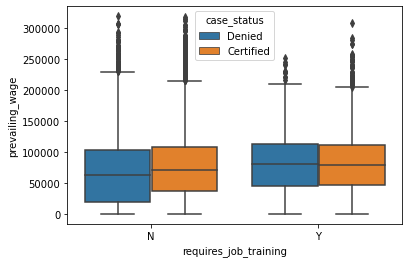

In [23]:
#viewing certification status and wage by requires job training
sns.boxplot(data = data2, x ='requires_job_training', y ='prevailing_wage',hue='case_status')

#interestingly, under requires job training = N, there is a lower limit on wage when denied

<AxesSubplot:xlabel='has_job_experience', ylabel='prevailing_wage'>

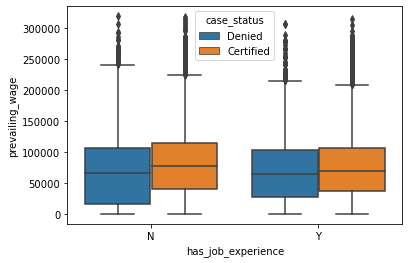

In [24]:
#viewing certification status and wage by has_job_experience     
sns.boxplot(data = data2, x ='has_job_experience', y ='prevailing_wage',hue='case_status')

#more of the same trends 

<AxesSubplot:xlabel='case_status', ylabel='no_of_employees'>

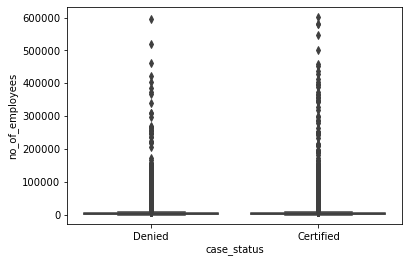

In [25]:
#viewing certification status and number of employees      
sns.boxplot(data = data2, x ='case_status', y ='no_of_employees')

#the view is quite squashed due to the outliers

(array([2.5311e+04, 1.1200e+02, 3.2000e+01, 1.8000e+01, 7.0000e+00]),
 array([-2.60000e+01,  1.20393e+05,  2.40812e+05,  3.61231e+05,
         4.81650e+05,  6.02069e+05]),
 <BarContainer object of 5 artists>)

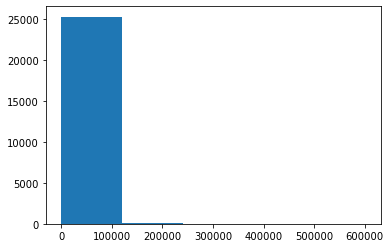

In [26]:
data2_employees = data2['no_of_employees']
plt.hist(data2_employees,bins = 5)

In [27]:
#printing tail of total employees to see outliers 
data2_employees.sort_values().tail(50)

#as I thought, there aren't just a few in this high range, it's a significant amount 

21303    252242
20290    252500
2400     253772
6615     256392
14616    256640
19497    262246
15068    264952
18584    267864
12625    268819
10453    278152
1284     283641
1409     288512
19529    296252
709      298041
25004    299942
14072    310467
23907    310628
11199    317150
7321     326338
21238    338605
1989     342120
13348    346352
3167     349050
6526     355726
516      358352
8717     364436
6856     366691
16716    367311
799      372064
17528    373353
19456    386278
15089    389595
979      394921
4749     397360
15925    403959
4137     404715
3864     412207
4120     421062
3731     428773
13144    437064
23176    453142
24071    459450
8626     461527
15268    499720
2783     517884
9587     547172
11317    579004
20345    581468
1345     594472
21339    602069
Name: no_of_employees, dtype: int64

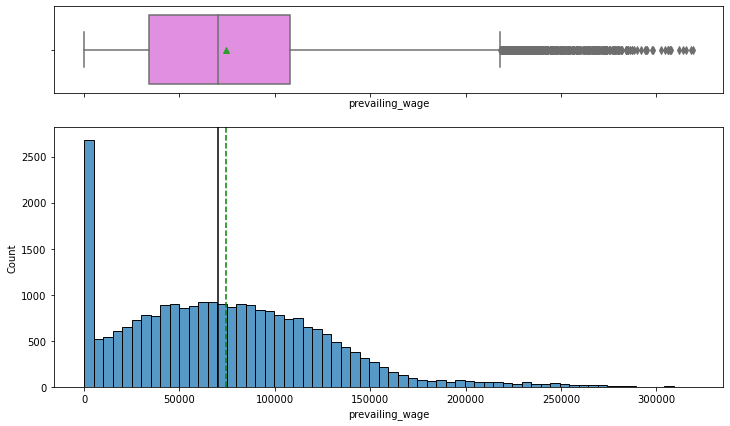

In [28]:
#creating histogram of prevailing_wage 
histogram_boxplot(data2,'prevailing_wage')

#big spike at low end

In [29]:
#showing min wage
data2['prevailing_wage'].min()

2

In [30]:
data2_lowwage = data2 [ (data2['prevailing_wage'] < 50)]

data2_lowwage['prevailing_wage'].value_counts()

44    4
17    4
5     4
11    4
45    4
48    4
16    3
47    3
30    3
42    3
37    3
23    3
10    3
3     3
46    3
41    2
35    2
39    2
9     2
2     2
40    2
15    2
12    2
24    2
38    2
36    1
22    1
33    1
28    1
27    1
21    1
6     1
43    1
18    1
25    1
7     1
49    1
20    1
14    1
8     1
19    1
31    1
34    1
32    1
Name: prevailing_wage, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


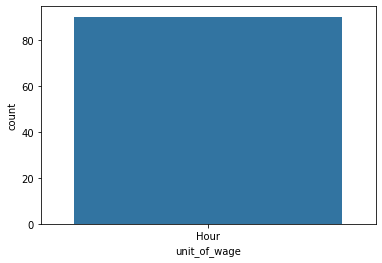

In [31]:
#showing if folks with low wage are hourly 
print(sns.countplot(data = data2_lowwage, x = 'unit_of_wage'))

#correct, they're all hourly, so I will not correct the wage 
#also $2 an hour...waitressing?? 

AxesSubplot(0.125,0.125;0.775x0.755)


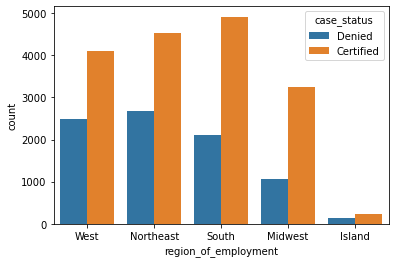

In [32]:
#barplot showing certification rate by region of employment
print(sns.countplot(data = data2, x = 'region_of_employment',hue='case_status'))

#Midwest has the highest certification rate, 75%
#Followed by South (70%)
#West, NE, and Island have rates between 60-63% certification rates 

In [33]:
#subsetting by Region 
data2_West = data2.query("region_of_employment == 'West'")  
data2_Northeast = data2.query("region_of_employment == 'Northeast'")  
data2_South = data2.query("region_of_employment == 'South'")  
data2_Midwest = data2.query("region_of_employment == 'Midwest'")  
data2_Island = data2.query("region_of_employment == 'Island'")     

In [34]:
print(color.BOLD + "West" + color.END)
print(data2_West['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

print(color.BOLD + "Northeast" + color.END)
print(data2_Northeast['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

print(color.BOLD + "South" + color.END)
print(data2_South['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

print(color.BOLD + "Midwest" + color.END)
print(data2_Midwest['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

print(color.BOLD + "Island" + color.END)
print(data2_Island['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)


West
Certified    62.3%
Denied       37.7%
Name: case_status, dtype: object

*************************
Northeast
Certified    62.9%
Denied       37.1%
Name: case_status, dtype: object

*************************
South
Certified    70.0%
Denied       30.0%
Name: case_status, dtype: object

*************************
Midwest
Certified    75.5%
Denied       24.5%
Name: case_status, dtype: object

*************************
Island
Certified    60.3%
Denied       39.7%
Name: case_status, dtype: object

*************************


AxesSubplot(0.125,0.125;0.775x0.755)


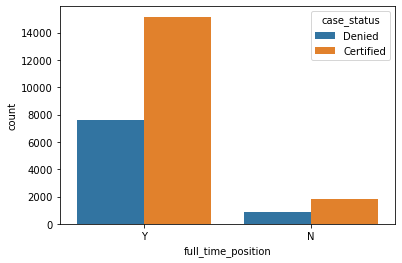

In [35]:
#barplot for full_time_position certification rate 
print(sns.countplot(data = data2, x = 'full_time_position',hue='case_status'))

In [36]:
#subsetting by full_time_poisiton
data2_full_time = data2.query("full_time_position == 'Y'") 
data2_part_time = data2.query("full_time_position == 'N'")  

In [37]:
#printing cert rate for full_time_position
print(color.BOLD + "Full Time" + color.END)
print(data2_full_time['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

print(color.BOLD + "Part Time" + color.END)
print(data2_part_time['case_status'].value_counts(normalize = True).mul(100).round(1).astype(str)+'%')
print("")
print("*"*25)

#full and part time have similar certification rates 

Full Time
Certified    66.6%
Denied       33.4%
Name: case_status, dtype: object

*************************
Part Time
Certified    68.5%
Denied       31.5%
Name: case_status, dtype: object

*************************


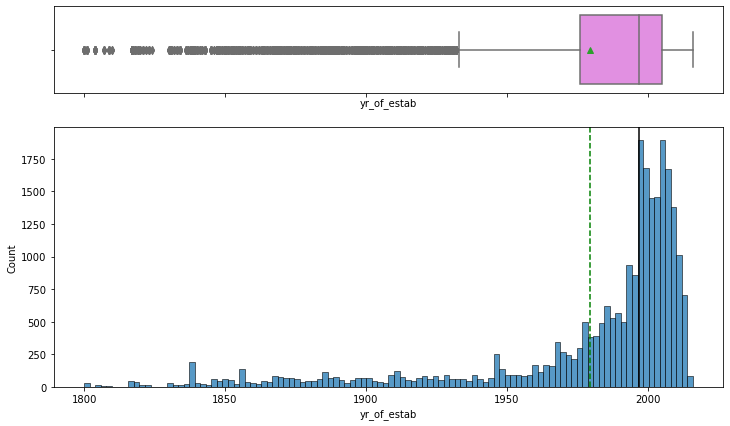

In [38]:
#histogram for year_of_estab
histogram_boxplot(data2,'yr_of_estab')

In [39]:
total_yrs_estab = pd.DataFrame(data2['yr_of_estab'].unique())
total_yrs_estab.shape

#There are 199 unique years established, will not bin or dummy 

(199, 1)

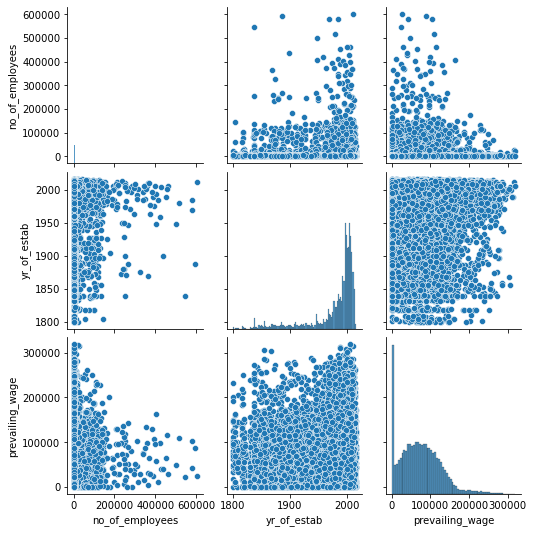

In [40]:
#pairplot for all items
sns.pairplot(data2)

#there is a slightly negative correlation between prevailing_wage and no_of_employees 

<AxesSubplot:>

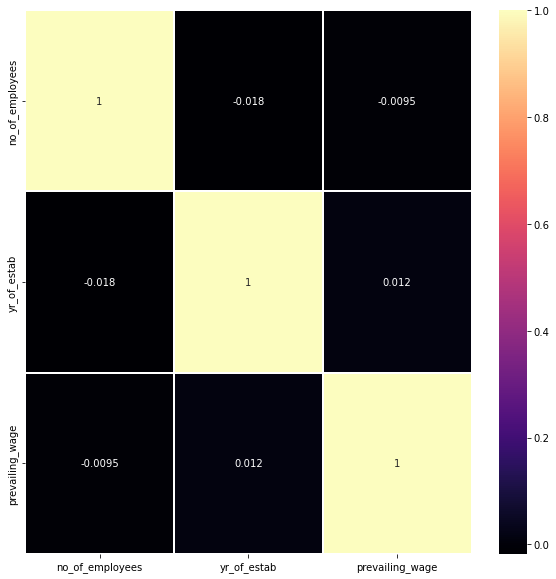

In [41]:
#heatmap for correlation
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(data2.corr(), ax=ax, annot=True, linewidths=0.05,cmap='magma') 	

#confirmed negative correlation between no_of_employees and prevailing_wage 
#also see correlation between no_of_employees and yr_of_estab

## Data Preprocessing

- Missing value treatment (if needed)
- Feature engineering 
- Outlier detection and treatment (if needed)
- Preparing data for modeling 
- Any other preprocessing steps (if needed)

#### Missing Value Check

In [42]:
#missing value check
#no missing values to remove 
data2.isnull().sum()

continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

#### Feature Engineering & Dummy Variables

- Converting to integers
	- has_job_experience
	- requires_job_training
	- education_of_employee (convert into # ordered by value)
	- full_time_position
	- case_status

- Dummy Variables
    - continent
	- yr_of_estab 
	- region_of_employment
	- unit_of_wage

In [43]:
#converting has_job_experience to integers 

#confirming unique values 
print(data2['has_job_experience'].unique())

['N' 'Y']


In [44]:
#replacing N with 0, Y with 1
data2["has_job_experience"].replace({"N": "0", "Y": "1"}, inplace=True)

data2.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,0,N,14513,2007,West,592,Hour,Y,Denied
1,Asia,Master's,1,N,2412,2002,Northeast,83425,Year,Y,Certified
2,Asia,Bachelor's,0,Y,44444,2008,West,122996,Year,Y,Denied
3,Asia,Bachelor's,0,N,98,1897,West,83434,Year,Y,Denied
4,Africa,Master's,1,N,1082,2005,South,149907,Year,Y,Certified


In [45]:
#converting requires_job_training to integers 

#confirming unique values 
print(data2['requires_job_training'].unique())

['N' 'Y']


In [46]:
#replacing N with 0, Y with 1
data2["requires_job_training"].replace({"N": "0", "Y": "1"}, inplace=True)

data2.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,0,0,14513,2007,West,592,Hour,Y,Denied
1,Asia,Master's,1,0,2412,2002,Northeast,83425,Year,Y,Certified
2,Asia,Bachelor's,0,1,44444,2008,West,122996,Year,Y,Denied
3,Asia,Bachelor's,0,0,98,1897,West,83434,Year,Y,Denied
4,Africa,Master's,1,0,1082,2005,South,149907,Year,Y,Certified


In [47]:
#converting education_of_employee  to integers 

#confirming unique values 
print(data2['education_of_employee'].unique())

['High School' "Master's" "Bachelor's" 'Doctorate']


In [48]:
#replacing education levels with numbers in value order 
data2["education_of_employee"].replace({
    "High School": "1", 
    "Bachelor's": "2", 
    "Master's": "3", 
    "Doctorate": "4"
}, inplace=True)

data2.head().T

,0,1,2,3,4
continent,Asia,Asia,Asia,Asia,Africa
education_of_employee,1,3,2,2,3
has_job_experience,0,1,0,0,1
requires_job_training,0,0,1,0,0
no_of_employees,14513,2412,44444,98,1082
yr_of_estab,2007,2002,2008,1897,2005
region_of_employment,West,Northeast,West,West,South
prevailing_wage,592,83425,122996,83434,149907
unit_of_wage,Hour,Year,Year,Year,Year
full_time_position,Y,Y,Y,Y,Y


In [49]:
#converting full_time_position  to integers 

#confirming unique values 
print(data2['full_time_position'].unique())

['Y' 'N']


In [50]:
#replacing N with 0, Y with 1
data2["full_time_position"].replace({"N": "0", "Y": "1"}, inplace=True)

data2.head().T

,0,1,2,3,4
continent,Asia,Asia,Asia,Asia,Africa
education_of_employee,1,3,2,2,3
has_job_experience,0,1,0,0,1
requires_job_training,0,0,1,0,0
no_of_employees,14513,2412,44444,98,1082
yr_of_estab,2007,2002,2008,1897,2005
region_of_employment,West,Northeast,West,West,South
prevailing_wage,592,83425,122996,83434,149907
unit_of_wage,Hour,Year,Year,Year,Year
full_time_position,1,1,1,1,1


In [51]:
#converting case_status  to integers 

#confirming unique values 
print(data2['case_status'].unique())

['Denied' 'Certified']


In [52]:
#replacing Denied with 0, Certified with 1
data2["case_status"].replace({"Denied": "0", "Certified": "1"}, inplace=True)

data2.head().T

,0,1,2,3,4
continent,Asia,Asia,Asia,Asia,Africa
education_of_employee,1,3,2,2,3
has_job_experience,0,1,0,0,1
requires_job_training,0,0,1,0,0
no_of_employees,14513,2412,44444,98,1082
yr_of_estab,2007,2002,2008,1897,2005
region_of_employment,West,Northeast,West,West,South
prevailing_wage,592,83425,122996,83434,149907
unit_of_wage,Hour,Year,Year,Year,Year
full_time_position,1,1,1,1,1


#### Fixing some bad data quality and confirming outliers

In [53]:
#setting no_of_employees as absolute value 
data2['no_of_employees'] = data2['no_of_employees'].abs()

#confirming change 
data2['no_of_employees'].head(50).sort_values(ascending=True).T

28        18
37        44
3         98
47       226
24       241
26       756
29       758
19       843
20       880
31       995
4       1082
25      1100
41      1209
30      1408
23      1517
13      1652
21      1706
34      1809
45      2092
49      2171
38      2206
9       2251
5       2339
33      2395
48      2405
1       2412
32      2415
10      2465
36      2520
43      2582
46      2623
17      2747
22      2878
27      2889
7       3035
40      3723
39      3729
11      4069
18      4743
8       4810
15      4897
6       4985
44      5407
35      5512
0      14513
14     15756
42     19770
2      44444
16     76638
12    123876
Name: no_of_employees, dtype: int64

In [54]:
#verifying some of the prevailing wage values 
data2.head(30).sort_values(by=['prevailing_wage'],ascending=True)

#NOTE: Confirmed in earlier EDA that the "outliers" appear to be legitimate
#not removing any outliers 

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
7,North America,2,1,0,3035,1924,West,418,Hour,1,0
0,Asia,1,0,0,14513,2007,West,592,Hour,1,0
16,Europe,3,1,0,76638,1991,Midwest,3706,Year,1,1
17,Asia,3,1,0,2747,2001,West,16132,Year,1,1
12,Asia,2,1,0,123876,1963,Northeast,28663,Year,1,1
28,Asia,3,1,0,18,2004,Northeast,40925,Year,1,1
22,Asia,3,1,0,2878,1968,West,45642,Year,1,1
6,Asia,2,0,0,4985,1994,South,53635,Year,1,1
9,Europe,4,1,0,2251,1995,South,67514,Year,1,1
11,Asia,1,1,0,4069,2005,Northeast,70813,Year,1,0


#### Creating Dummy Variables 

In [55]:
#converting continent, region_of_employment,unit_of_wage to dummies
dummyCols=["region_of_employment","continent","unit_of_wage"]

data2=pd.get_dummies(data2, columns=dummyCols)

#### Converting data to int to create model

In [56]:
data2.head().T

,0,1,2,3,4
education_of_employee,1,3,2,2,3
has_job_experience,0,1,0,0,1
requires_job_training,0,0,1,0,0
no_of_employees,14513,2412,44444,98,1082
yr_of_estab,2007,2002,2008,1897,2005
prevailing_wage,592,83425,122996,83434,149907
full_time_position,1,1,1,1,1
case_status,0,1,0,0,1
region_of_employment_Island,0,0,0,0,0
region_of_employment_Midwest,0,0,0,0,0


In [57]:
#checking data types 
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   education_of_employee           25480 non-null  object
 1   has_job_experience              25480 non-null  object
 2   requires_job_training           25480 non-null  object
 3   no_of_employees                 25480 non-null  int64 
 4   yr_of_estab                     25480 non-null  int64 
 5   prevailing_wage                 25480 non-null  int64 
 6   full_time_position              25480 non-null  object
 7   case_status                     25480 non-null  object
 8   region_of_employment_Island     25480 non-null  uint8 
 9   region_of_employment_Midwest    25480 non-null  uint8 
 10  region_of_employment_Northeast  25480 non-null  uint8 
 11  region_of_employment_South      25480 non-null  uint8 
 12  region_of_employment_West       25480 non-null

In [58]:
#converting to integers 
data2=data2.astype('int64')
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   education_of_employee           25480 non-null  int64
 1   has_job_experience              25480 non-null  int64
 2   requires_job_training           25480 non-null  int64
 3   no_of_employees                 25480 non-null  int64
 4   yr_of_estab                     25480 non-null  int64
 5   prevailing_wage                 25480 non-null  int64
 6   full_time_position              25480 non-null  int64
 7   case_status                     25480 non-null  int64
 8   region_of_employment_Island     25480 non-null  int64
 9   region_of_employment_Midwest    25480 non-null  int64
 10  region_of_employment_Northeast  25480 non-null  int64
 11  region_of_employment_South      25480 non-null  int64
 12  region_of_employment_West       25480 non-null  int64
 13  c

## EDA

- Additional findings with dummy variable breakout: 
    - North america less likely to have yearly wage (hire more hourly wage?) 
    - yearly wage sliiightly (0.2) more likely to be certified, hourly less 
    - has job experience 0.19 more likely to be certified 
    - education_of_employee 0.32 more likely to be certified 

In [59]:
for feature in data2.columns: #loop through columns 
        print(color.BOLD + color.BLUE + feature + color.END)
        print(data2[feature].describe())
        print("")
        print("*"*25)

education_of_employee
count    25480.000000
mean         2.415934
std          0.826718
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: education_of_employee, dtype: float64

*************************
has_job_experience
count    25480.000000
mean         0.580926
std          0.493417
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: has_job_experience, dtype: float64

*************************
requires_job_training
count    25480.000000
mean         0.115973
std          0.320199
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: requires_job_training, dtype: float64

*************************
no_of_employees
count     25480.000000
mean       5667.089207
std       22877.917453
min          11.000000
25%        1022.000000
50%        2109.000000
75%        3504.000000
max      602069.000000

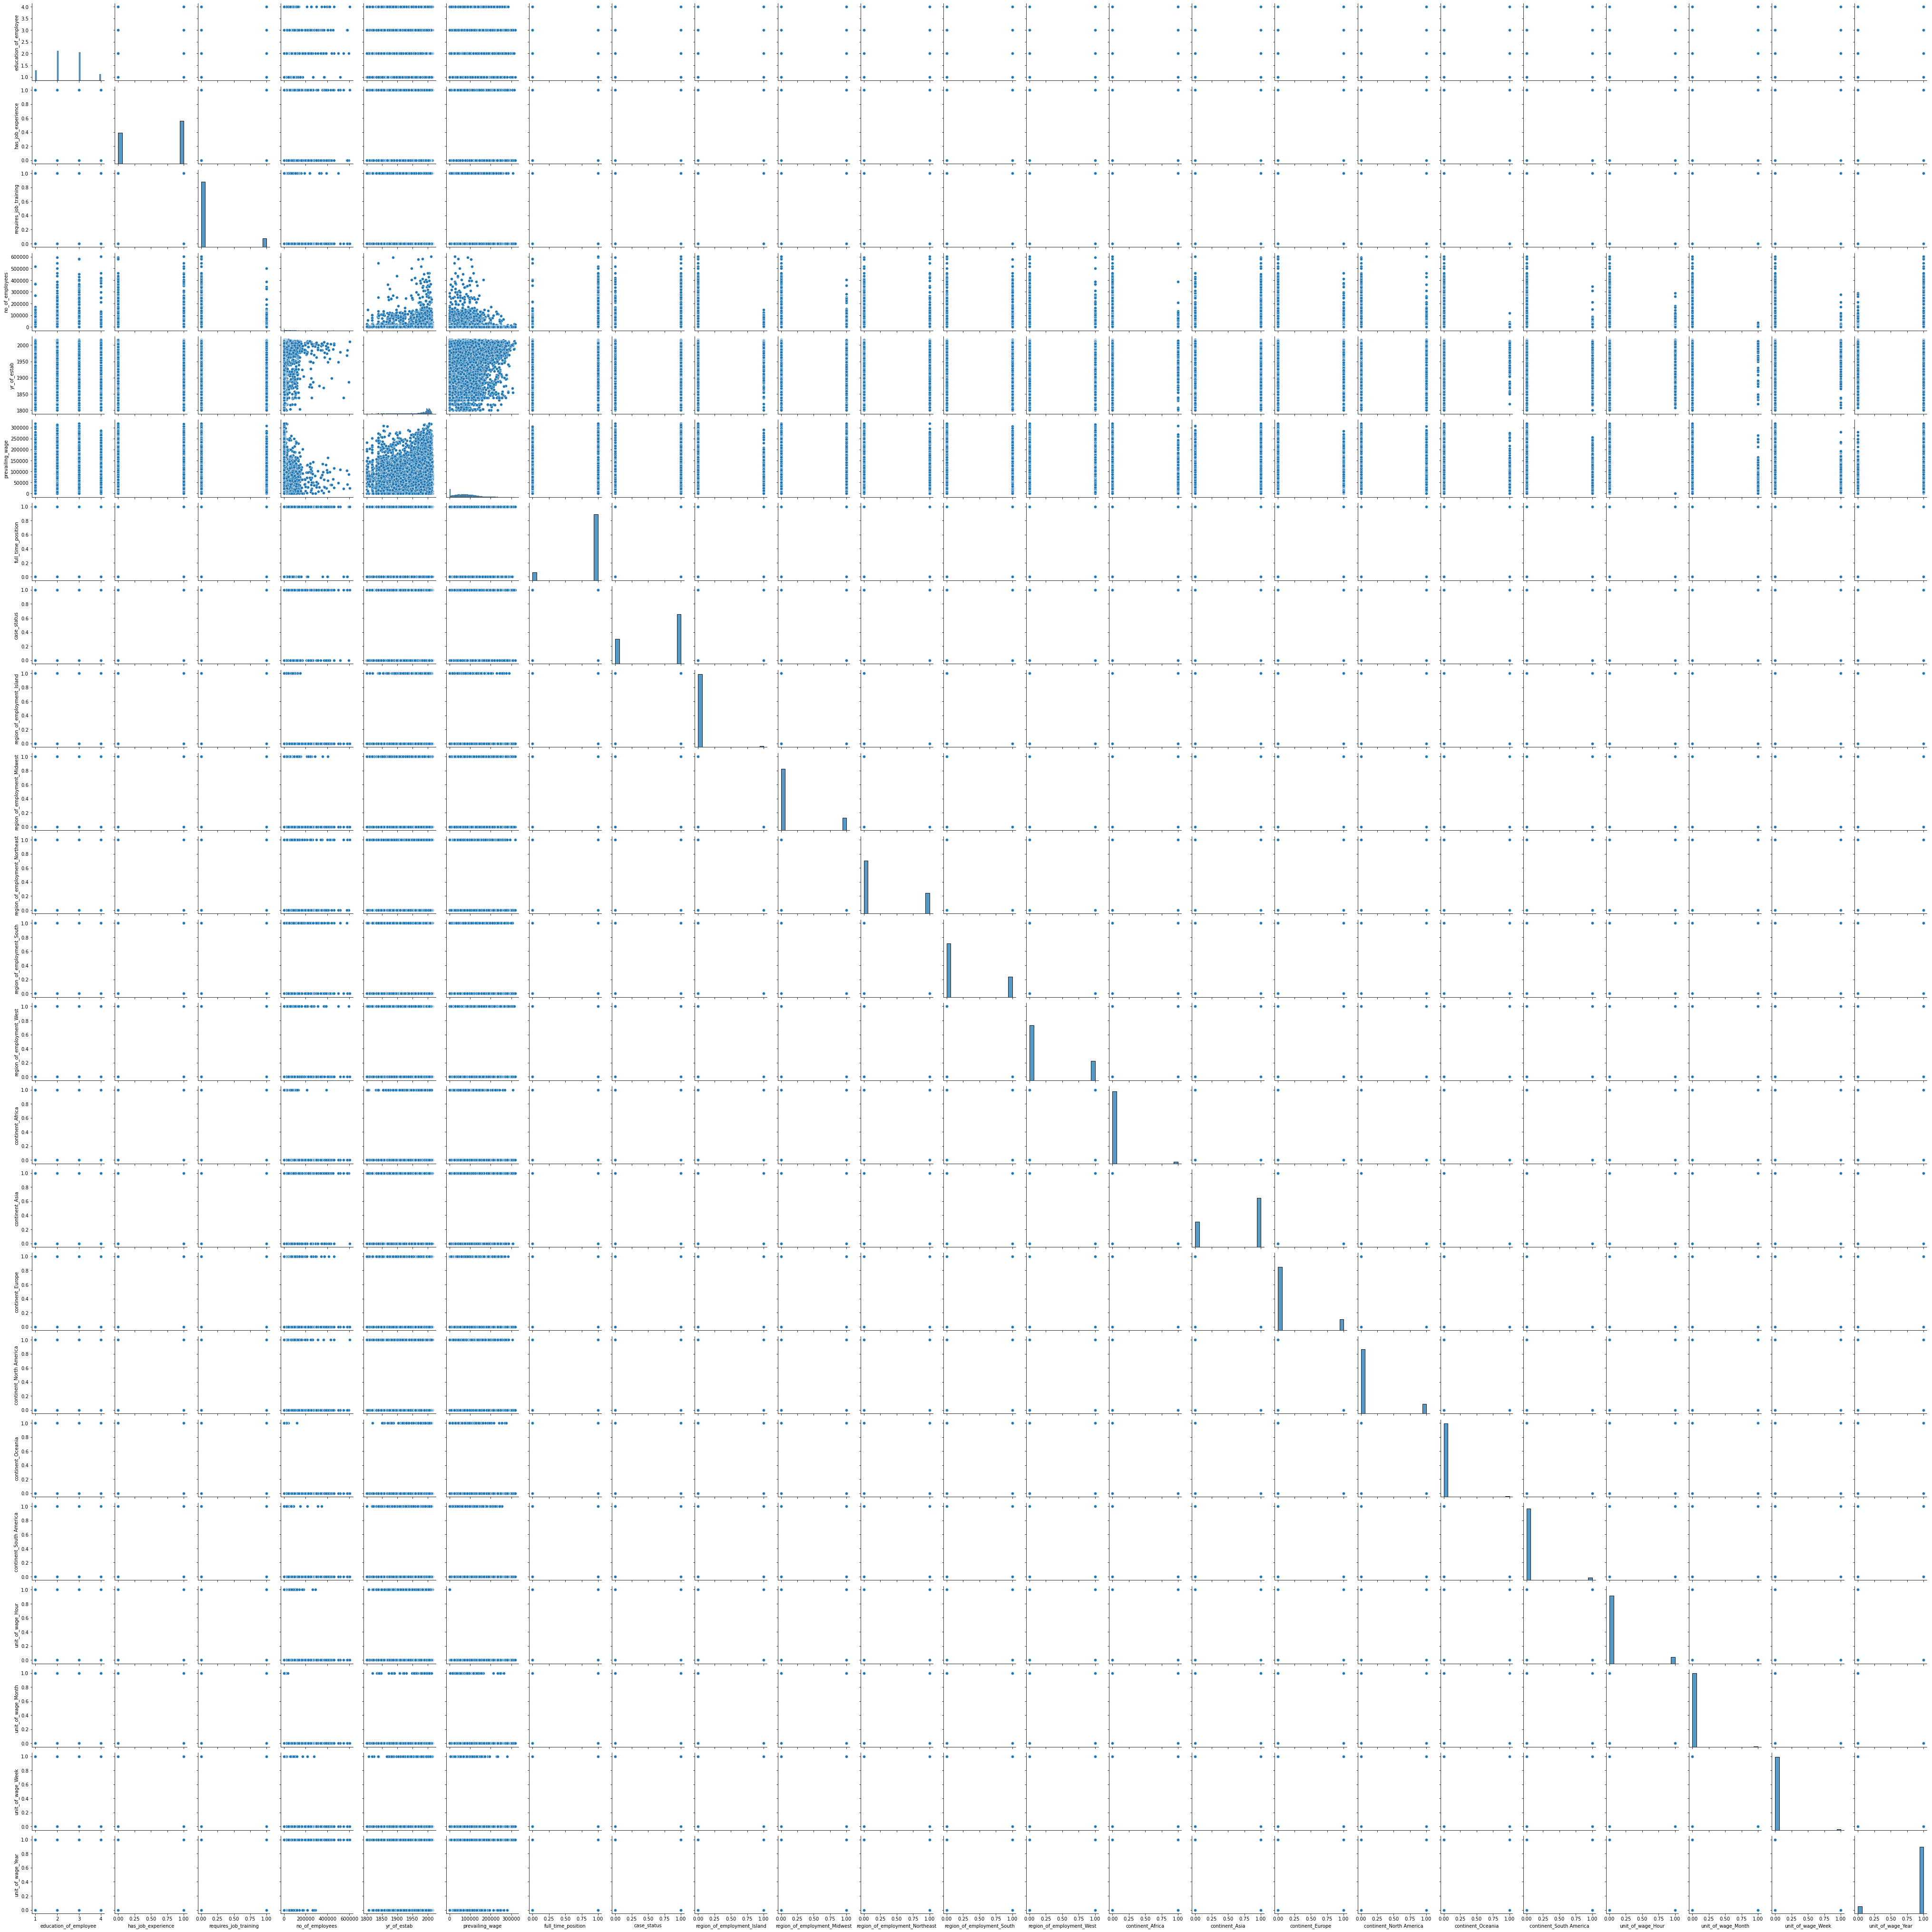

In [60]:
#pairplot for all items
sns.pairplot(data2)

<AxesSubplot:>

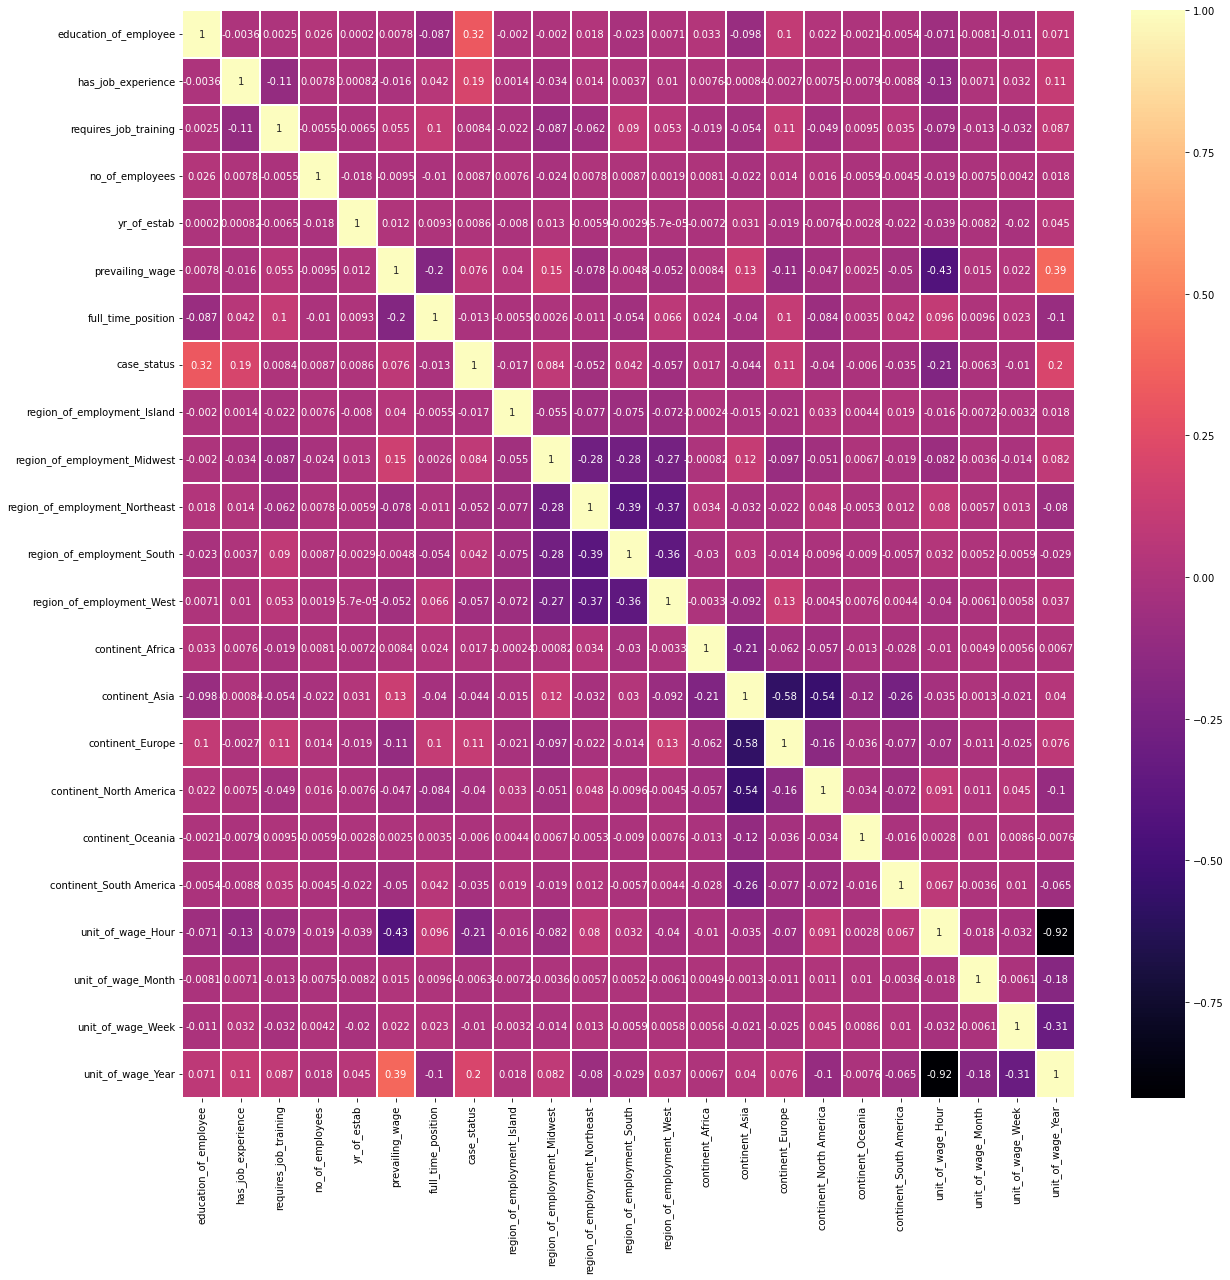

In [61]:
#heatmap
fig,ax = plt.subplots(figsize=(20,20))
sns.heatmap(data2.corr(), ax=ax, annot=True, linewidths=0.05,cmap='magma') 	

#Additional findings with dummy variable breakout: 
    #North america less likely to have yearly wage (hire more hourly wage?) 
    #yearly wage sliiightly (0.2) more likely to be certified, hourly less 
    #has job experience 0.19 more likely to be certified 
    #education_of_employee 0.32 more likely to be certified 

### Split Data into train and test sets 
- ensuring we stratify the data to replicate initial dataset: 
    - 67% Certified, 33% Denied

In [62]:
#removing our target variable case_status from main dataset, setting to y
X = data2.drop("case_status" , axis=1)
y = data2.pop("case_status")

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1,stratify=y)

## Building bagging models

### Building Decision Tree classifier

In [72]:
#build decision tree classifier 
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [78]:
#Calculate accuracy, recall and precision on train and test set
dTree_score=get_metrics_score(dTree)

#perfectly fit the train data
#alright for test set, low on accuracy
#highish on recall and about the same on precision

Accuracy on training set :  1.0
Accuracy on test set :  0.6577708006279435
Recall on training set :  1.0
Recall on test set :  0.7392752203721842
Precision on training set :  1.0
Precision on test set :  0.7459972326546749


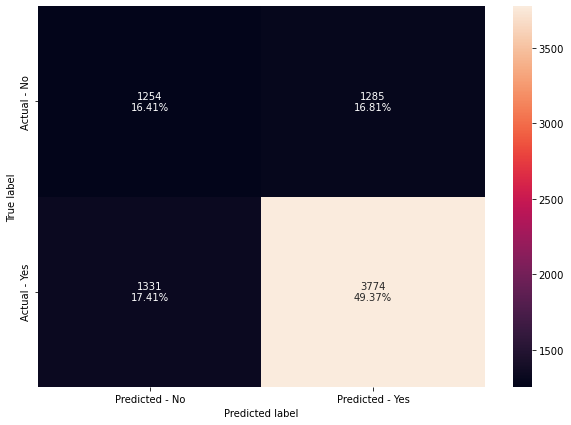

In [79]:
#confusion matrix - basic decision tree
make_confusion_matrix(dTree,y_test)

### Building Bagging Classifier w/ Decision Tree base estimator

In [65]:
#base_estimator for bagging classifier is a decision tree by default
bagging_estimator=BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train,y_train)

BaggingClassifier(random_state=1)

In [80]:
#Calculate accuracy, recall and precision on train and test set
bagging_estimator_score=get_metrics_score(bagging_estimator)

#performed better than basic decision tree

Accuracy on training set :  0.9834604171338865
Accuracy on test set :  0.6972789115646258
Recall on training set :  0.984302862419206
Recall on test set :  0.7702252693437807
Precision on training set :  0.990873753591347
Precision on test set :  0.775083776857875


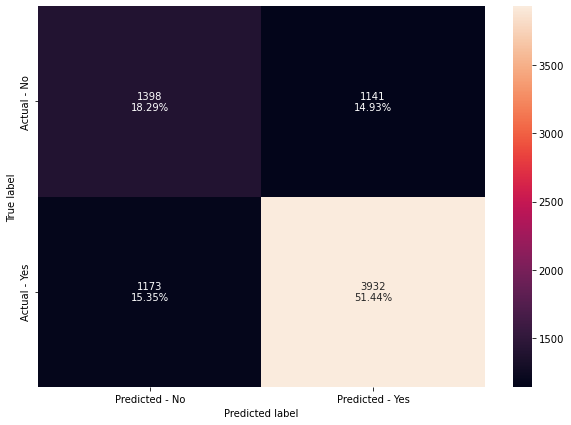

In [81]:
#confusion matrix - bagging estimator w/ decision tree
make_confusion_matrix(bagging_estimator,y_test)

#again, better than decision tree 

### Building Random Forest  classifier

In [82]:
#Train the random forest classifier
rf_estimator=RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [83]:
#Calculate accuracy, recall and precision on train and test set
bagging_estimator_score=get_metrics_score(rf_estimator)

#better than decision tree and bagging w/ decision tree
#still WAY overfitting. 

Accuracy on training set :  1.0
Accuracy on test set :  0.7230507587650444
Recall on training set :  1.0
Recall on test set :  0.8364348677766895
Precision on training set :  1.0
Precision on test set :  0.7690922190201729


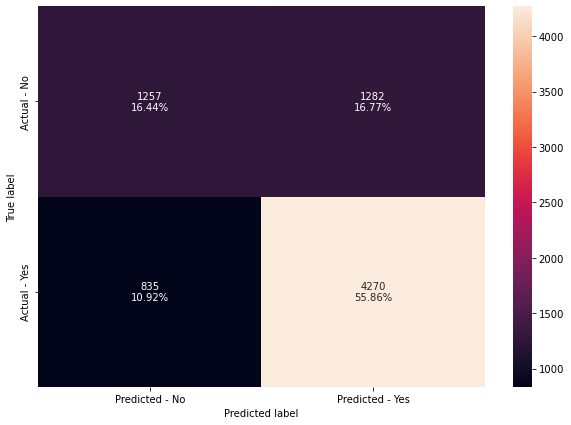

In [84]:
#confusion matrix - bagging estimator w/ decision tree
make_confusion_matrix(rf_estimator,y_test)

## Building boosting models

### Building Adaboost 

In [85]:
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train,y_train)

AdaBoostClassifier(random_state=1)

In [89]:
#Calculate accuracy, recall and precision on train and test set
bagging_estimator_score=get_metrics_score(abc)

#not nearly as overfit 
#best model so far 

Accuracy on training set :  0.7375532630634671
Accuracy on test set :  0.7337781266352695
Recall on training set :  0.8893645597246705
Recall on test set :  0.8865817825661116
Precision on training set :  0.7590629029946984
Precision on test set :  0.7566031427616182


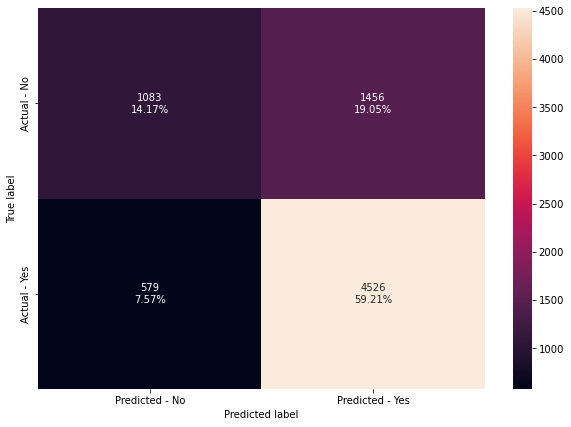

In [90]:
#confusion matrix - bagging estimator w/ decision tree
make_confusion_matrix(abc,y_test)

#peep that low FN! 

### Building GradientBoost 

In [91]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

In [100]:
#Calculate accuracy, recall and precision on train and test set
gradientboost_score=get_metrics_score(gbc)

#higher accuracy and precision but sliiightly lower recall 

Accuracy on training set :  0.7570082978246243
Accuracy on test set :  0.7458137100994244
Recall on training set :  0.8819776714513556
Recall on test set :  0.877179236043095
Precision on training set :  0.7820617789356159
Precision on test set :  0.772868484639282


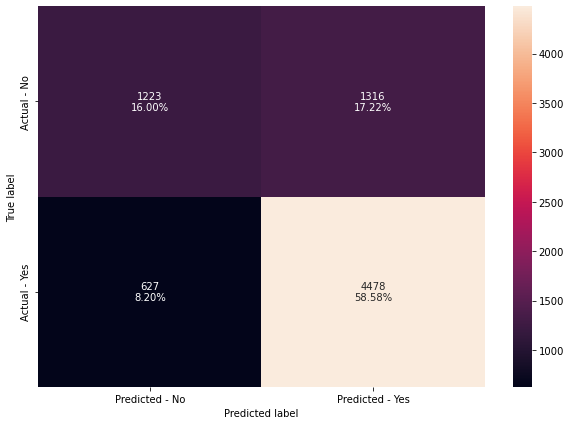

In [93]:
#confusion matrix - bagging estimator w/ decision tree
make_confusion_matrix(gbc,y_test)

##  Will tuning the hyperparameters improve the model performance?

### Tuning Decision Tree 

In [103]:
# Choose the type of classifier. 
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [2, 3, 5, 10]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
estimator.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2, random_state=1)

In [104]:
#Calculate accuracy, recall and precision on train and test set
tuned_dTree_score=get_metrics_score(estimator)

#improved recall phenomenally!
#precision lowered - 6% - not ok 
#accuracy also lower 

Accuracy on training set :  0.7125476564252075
Accuracy on test set :  0.706567242281528
Recall on training set :  0.9319231092084278
Recall on test set :  0.9308521057786484
Precision on training set :  0.7200674536256324
Precision on test set :  0.7154471544715447


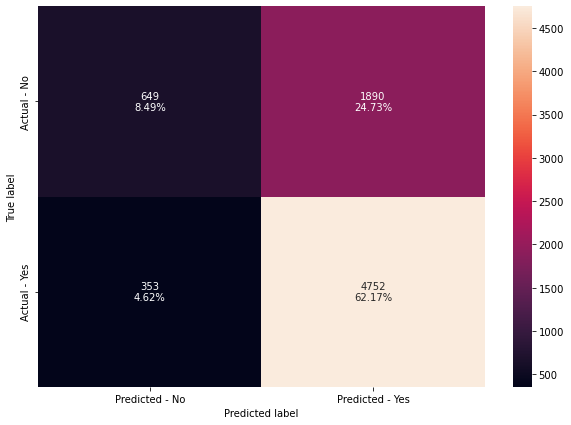

In [105]:
#confusion matrix - bagging estimator w/ decision tree
make_confusion_matrix(estimator,y_test)

#### Decision Tree tuning impact insights: 
- Tuning the decision tree using gridsearch improved recall, but lowered precision 6% 
- this is too much for my preference - we want precision higher 
- Also, accuracy decreased 

### Tuning Bagging classifier w/ Decision Tree

In [106]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [25,50,100,150,200],
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.7, max_samples=1, n_estimators=25,
                  random_state=1)

In [107]:
#Calculate accuracy, recall and precision on train and test set
bagging_estimator_tuned_score=get_metrics_score(bagging_estimator_tuned)

#this tuning essentailly didn't submit any negatives
#recall perfect but huge ding on accuracy and precision 

Accuracy on training set :  0.6679188158779995
Accuracy on test set :  0.6678440607012036
Recall on training set :  1.0
Recall on test set :  1.0
Precision on training set :  0.6679188158779995
Precision on test set :  0.6678440607012036


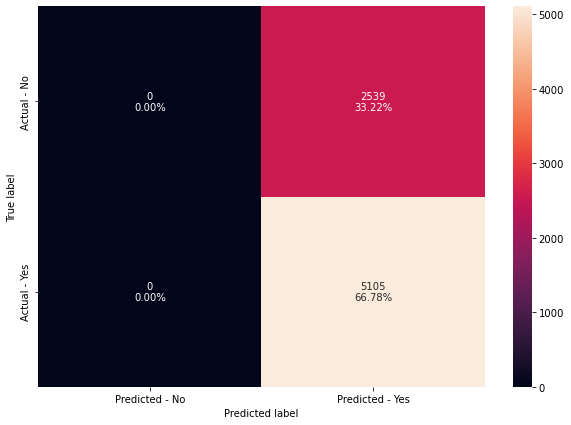

In [108]:
#confusion matrix - bagging estimator w/ decision tree
make_confusion_matrix(bagging_estimator_tuned,y_test)

#recall 100%, made 0 negative predictions. We don't want that. 

#### Bagging tuning impact insights: 

- tuning parameters chosen worsened the end result 
- led to a model which predicted no denials
- this is the exact opposite of what we wanted 

### Tuning Random Forest model

In [112]:
# Choose the type of classifier. 
rf_estimator_tuned = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "class_weight": [{0: 0.3, 1: 0.7}],
    "n_estimators": [150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1)
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_estimator_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, max_features=0.2,
                       max_samples=0.3, min_samples_leaf=9, n_estimators=250,
                       random_state=1)

In [121]:
#Calculate accuracy, recall and precision on train and test set
rf_estimator_tuned_score=get_metrics_score(rf_estimator_tuned)

#pretty low accuracy and precision while boostin recall 

Accuracy on training set :  0.7106974657995067
Accuracy on test set :  0.6980638409209837
Recall on training set :  0.9841349785948124
Recall on test set :  0.9794319294809011
Precision on training set :  0.7022461814914646
Precision on test set :  0.6941552131056504


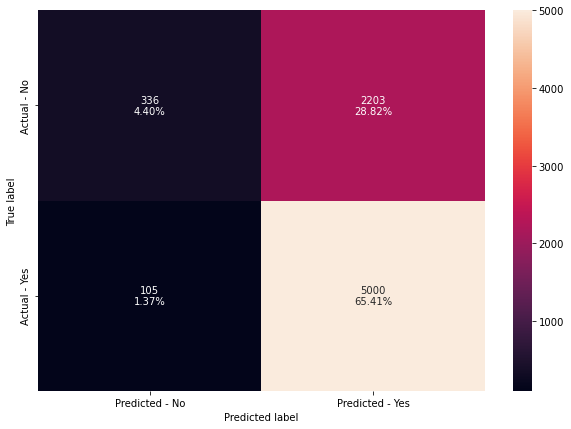

In [114]:
#confusion matrix - bagging estimator w/ decision tree
make_confusion_matrix(rf_estimator_tuned,y_test)

#### Random Forest tuning impact insights: 
- Not as extreme as the bagging settings
- Tuning made a similar adjustment favoring recall too much at the expense of precision 
- Almost no negative predictions were made 

### Tuning Adaboost

In [136]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": np.arange(10,110,10),
    "learning_rate": np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=10, random_state=1)

In [137]:
#Calculate accuracy, recall and precision on train and test set
abc_tuned=get_metrics_score(abc_tuned)

Accuracy on training set :  0.6918030948643193
Accuracy on test set :  0.6899529042386185
Recall on training set :  0.9716276336774952
Recall on test set :  0.9719882468168463
Precision on training set :  0.6917055097406478
Precision on test set :  0.6902211712338294


#### Adaboost tuning impact insights: 
- this tuning had a similar impact as tuning the random forest 
- High recall, lower precision and accuracy 

### Tuning GradientBoost

In [122]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=1, random_state=1, subsample=0.8)

In [123]:
#Calculate accuracy, recall and precision on train and test set
gbc_tuned_score=get_metrics_score(gbc_tuned)

#again favoring recall but not as extreme as the others 

Accuracy on training set :  0.7309374299170217
Accuracy on test set :  0.7218733647305076
Recall on training set :  0.9316712834718375
Recall on test set :  0.9277179236043095
Precision on training set :  0.7358127817555025
Precision on test set :  0.729400893269675


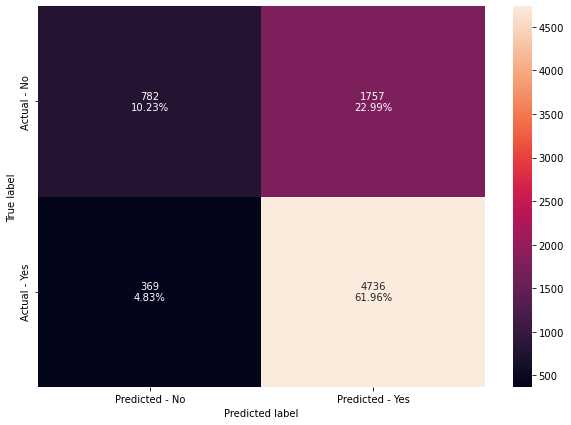

In [124]:
#confusion matrix - bagging estimator w/ decision tree
make_confusion_matrix(gbc_tuned,y_test)


#### GradientBoost tuning impact insights: 
- Another less extreme example of favoring recall 
- avoiding making negative predictions 
- precision and accuracy a little low still at 72%

## Model Performance Comparison and Conclusions

In [ ]:
# defining list of models
models = [
    dTree, 
    estimator, 
    bagging_estimator, 
    bagging_estimator_tuned, 
    rf_estimator, 
    rf_estimator_tuned, 
    gbc, 
    gbc_tuned, 
    abc,
    abc_tuned]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))

In [161]:
#manually appending tuned adaboost final column 
acc_train.append(np.round(0.6918030948643193,2))
acc_test.append(np.round(0.6899529042386185,2))
recall_train.append(np.round(0.9716276336774952,2))
recall_test.append(np.round(0.9719882468168463,2))
precision_train.append(np.round(0.6917055097406478,2))
precision_test.append(np.round(0.6902211712338294,2))
    

In [164]:
#checking length of lists 
metrics = [acc_train, acc_test, recall_train, recall_test, precision_train, 
           precision_test]

for i in metrics:
    print(len(i))

10
10
10
10
10
10


In [165]:
comparison_frame = pd.DataFrame({'Model':['Decision Tree Default', 
                                          'Decision Tree Tuned','Bagging Dtree Default',
                                          'Bagging Dtree Tuned','Random Forest Default', 
                                          'Random Forest Tuned', 'Gradient Boost Default',
                                          'Gradient Boost Tuned','Adaboost Defalt',
                                          'Adaboost Tuned'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Decision Tree Default,1.00,0.66,1.00,0.74,1.00,0.75
1,Decision Tree Tuned,0.71,0.71,0.93,0.93,0.72,0.72
2,Bagging Dtree Default,0.98,0.70,0.98,0.77,0.99,0.78
3,Bagging Dtree Tuned,0.67,0.67,1.00,1.00,0.67,0.67
4,Random Forest Default,1.00,0.72,1.00,0.84,1.00,0.77
5,Random Forest Tuned,0.71,0.70,0.98,0.98,0.70,0.69
6,Gradient Boost Default,0.76,0.75,0.88,0.88,0.78,0.77
7,Gradient Boost Tuned,0.73,0.72,0.93,0.93,0.74,0.73
8,Adaboost Defalt,0.74,0.73,0.89,0.89,0.76,0.76
9,Adaboost Tuned,0.69,0.69,0.97,0.97,0.69,0.69


## Gradient Boost Default Model is my final selection 
- Many of the models increased overfit or overly favored recall at the expense of precision 
- Gradient Boost before tuning had the highest accuracy and precision on almost all test metrics 
    - Note: Test precision on Bagging with Decision Tree was .01 higher
    - Test Accuracy: 0.75	
    - Test Recall: 0.88	
    - Test Precision: 0.77
- This model also performed similarly on train and test, indicating minimal overfitting  
    - delta of .01 or less on each metric 

This model balances our need for precision while also maintaining excellent metrics and avoiding overfitting

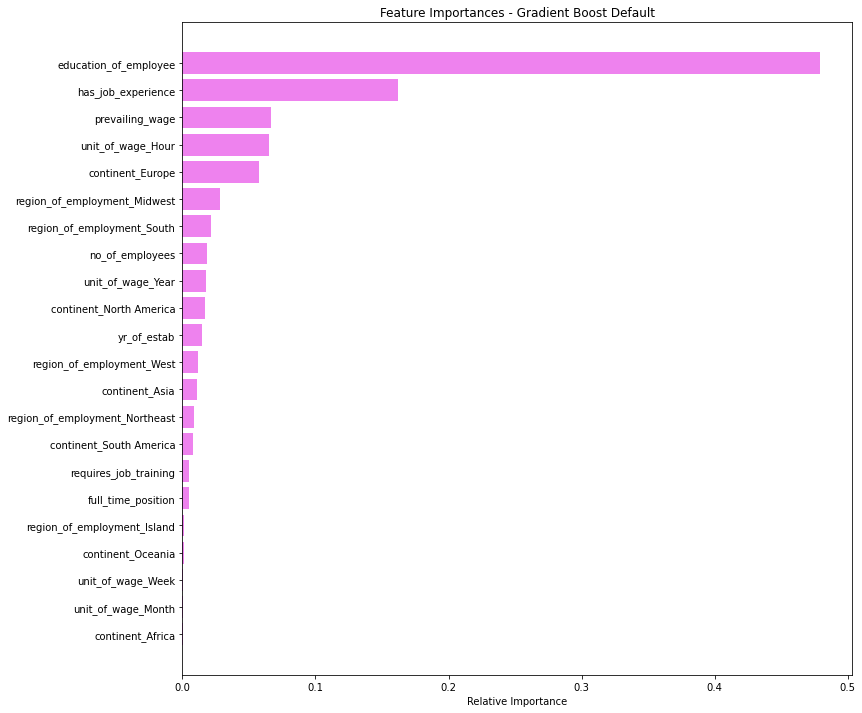

In [166]:
#Printing Importance of variables for our chosen model 
importances = gbc.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances - Gradient Boost Default')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Actionable Insights and Recommendations

### Primary Takeaways: 
- ***This model balances recall and precision***
    - This impacts how many individuals are added to the shortlist, limiting the total to reduce overwhelm but not limiting too much
    - To ensure we don't leave too many out, it still has a small False Positive to balance recall  
- When reviewing those on the short list, 
    - ***First prioritize reviewing those with higher education levels and with job experience***
    - ***Then review those with higher wages and Hourly wage***
        - Contractors typically function off of hourly wage, and can be exceptionally skilled and useful for short-term positions while the company searches for local talent 
        - However, *hourly wage can also indicate lower complexity of work*, so again fold in education level and job experience 
        - This will help ***filter out lower skill work*** that could easily be filled by in-country applicants 
    
**As always, each review is influencing someone's livelihood and giving them an opportunity for upward mobility!**
- Another reason I balanced precision and recall was to ensure we still review moderate level candidates that just need an opporunity to thrive 
- We don't want to waste time with those most likely to default
- Also, if there's a moderate chance of certification, they could have additional circumstances not reflected in their bare metrics that your company's attention will pick up on 

**From a wholistic perspective, review your application process as well**
- Simply limiting your influx is only one way to reduce overwhelm 
- Strongly recommend completing a process analysis on the steps to become certified
    - ***Number of forms*** - any duplicates to combine? Are the same questions asked in multiple forms that you can automate?
    - ***Approval touch bases*** - do you speak to the same person multiple times? Organize your questions to touch base once. 
    - ***Communication methods*** - utilize online and schedule applications (ex: Zoom and Schedule Once) to ease scheduling woes 
    - ***Feedback*** - regularly send feedback requests to your team. They are on the ground floor and are experts in what works (and what doesn't). Trust their experience.  
    - ***Document accessibility*** - If all items are online, review where you store certifications and how complex the document management process is. Can you adjust how you save the files so they are easier to access? Can you upgrade your tools so they run queries faster? 
    - ***Employee accessibility*** - If employees are working in office, review where they are sitting. Do they regularly collaborate with specific teams? Make sure they sit close together to ease communication. 
    - ***Monitor burnout*** - Your teams will perform at a higher rate if they are taken care of! 
        - Require PTO times, lunch breaks, etc.
        - Train managers to touch base with their teams and check if they need help with something
        - Review turnover in your teams - high turnover = higher training cost for new hires. Take care of your people and you'll save money and time. 
        
        
*Thank you for the opportunity! I hope these findings prove useful and help your company and applicants thrive to better our economy and country.*  